# 06. Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

**Scaling Up with Transfer Learning**

In this notebook, we'll take our transfer learning experiments to the next level by using more data. We'll scale up from 10 classes to all classes in the Food101 dataset.

**Our Goal**

Beat the original Food101 paper's results using only 10% of the data.

**What We'll Cover**

1. Downloading and preparing 10% of the Food101 data
2. Training a feature extraction transfer learning model
3. Fine-tuning the model
4. Saving and loading the trained model
5. Evaluating the model's performance
6. Making predictions on custom images of food

**How to Use This Notebook**

1. Read through the descriptions and code
2. Write the code yourself in a new notebook to get hands-on experience
3. Investigate and experiment with the code to learn more


In [1]:
# !pip install tensorflow==2.9.0

In [2]:
# !pip install -U -q tensorflow==2.9.0

In [3]:
!wget https://raw.githubusercontent.com/siddhant-rajhans/TensorFlow/main/Basics/helper/helper.py

--2024-09-13 07:36:49--  https://raw.githubusercontent.com/siddhant-rajhans/TensorFlow/main/Basics/helper/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9565 (9.3K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   9.34K  --.-KB/s    in 0s      

2024-09-13 07:36:49 (79.6 MB/s) - ‘helper.py’ saved [9565/9565]



In [4]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

In [5]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-09-13 07:36:58--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.196.207, 74.125.141.207, 173.194.210.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.196.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   225MB/s    in 6.8s    

2024-09-13 07:37:05 (229 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheesecake'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/sashimi'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/oysters'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/pulled_pork_sandwich'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/mussels'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_calamari'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/churros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tuna_tartare'.
There are 0 directories and 250 images in '

In [7]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [8]:
# Create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [9]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

In [10]:
len(train_data_all_10_percent.class_names), train_data_all_10_percent.class_names

(101,
 ['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheese_plate',
  'cheesecake',
  'chicken_curry',
  'chicken_quesadilla',
  'chicken_wings',
  'chocolate_cake',
  'chocolate_mousse',
  'churros',
  'clam_chowder',
  'club_sandwich',
  'crab_cakes',
  'creme_brulee',
  'croque_madame',
  'cup_cakes',
  'deviled_eggs',
  'donuts',
  'dumplings',
  'edamame',
  'eggs_benedict',
  'escargots',
  'falafel',
  'filet_mignon',
  'fish_and_chips',
  'foie_gras',
  'french_fries',
  'french_onion_soup',
  'french_toast',
  'fried_calamari',
  'fried_rice',
  'frozen_yogurt',
  'garlic_bread',
  'gnocchi',
  'greek_salad',
  'grilled_cheese_sandwich',
  'grilled_salmon',
  'guacamole',
  'gyoza',
  'hamburger',
  'hot_and_sour_soup',
  'hot_dog',
  'huevos_rancheros',
  

In [11]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs) # augment images (only happens during training phase)
x = base_model(x, training=False) # put the base model in inference mode so weights which need to stay frozen, stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Get a summary of model we've created
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_avg_pool_layer                │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [13]:
# Compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [14]:
# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # validate on only 15% of test data during training
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 67s 205ms/step - accuracy: 0.1252 - loss: 4.0823 - val_accuracy: 0.4168 - val_loss: 2.6937
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 72s 182ms/step - accuracy: 0.4140 - loss: 2.5994 - val_accuracy: 0.4587 - val_loss: 2.2054
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 84s 190ms/step - accuracy: 0.4865 - loss: 2.2006 - val_accuracy: 0.5302 - val_loss: 1.9217
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 80s 181ms/step - accuracy: 0.5264 - loss: 1.9736 - val_accuracy: 0.5432 - val_loss: 1.8383
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 81s 177ms/step - accuracy: 0.5630 - loss: 1.8032 - val_accuracy: 0.5776 - val_loss: 1.6651


In [15]:
# Evaluate on the whole test dataset
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 64s 81ms/step - accuracy: 0.5180 - loss: 1.8796


[1.8210406303405762, 0.5306534767150879]

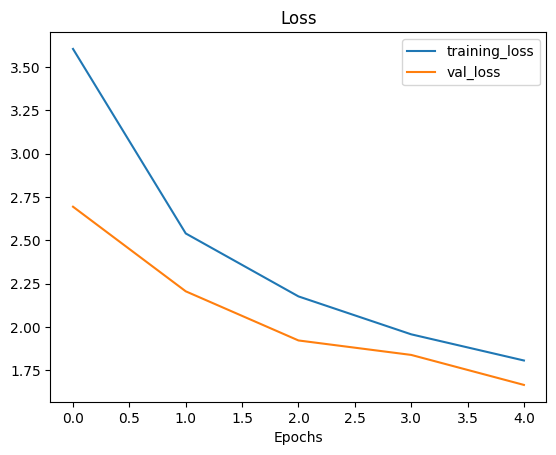

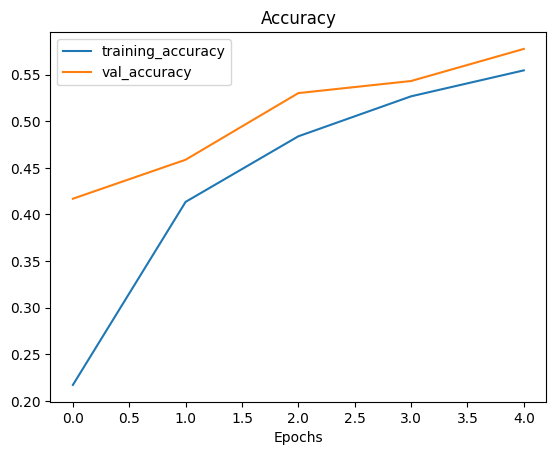

In [16]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [17]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [18]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate lowered by 10x
              metrics=["accuracy"])

In [19]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_avg_pool_layer True
output_layer True


In [20]:
# # Check which layers are trainable in our base model
# for layer_number, layer in enumerate(model.layers[2].layers):
#   print(layer_number, layer.name, layer.trainable)

In [21]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 57s 187ms/step - accuracy: 0.5737 - loss: 1.7803 - val_accuracy: 0.4979 - val_loss: 1.9764
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.6162 - loss: 1.5839 - val_accuracy: 0.5389 - val_loss: 1.7633
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 42s 178ms/step - accuracy: 0.6325 - loss: 1.4701 - val_accuracy: 0.6038 - val_loss: 1.5578
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 81s 173ms/step - accuracy: 0.6573 - loss: 1.3960 - val_accuracy: 0.5816 - val_loss: 1.6091
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 172ms/step - accuracy: 0.6650 - loss: 1.3490 - val_accuracy: 0.6165 - val_loss: 1.4793
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 171ms/step - accuracy: 0.6822 - loss: 1.2864 - val_accuracy: 0.6012 - val_loss: 1.4609


In [22]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 ━━━━━━━━━━━━━━━━━━━━ 62s 79ms/step - accuracy: 0.5529 - loss: 1.7002


[1.6131987571716309, 0.5740594267845154]

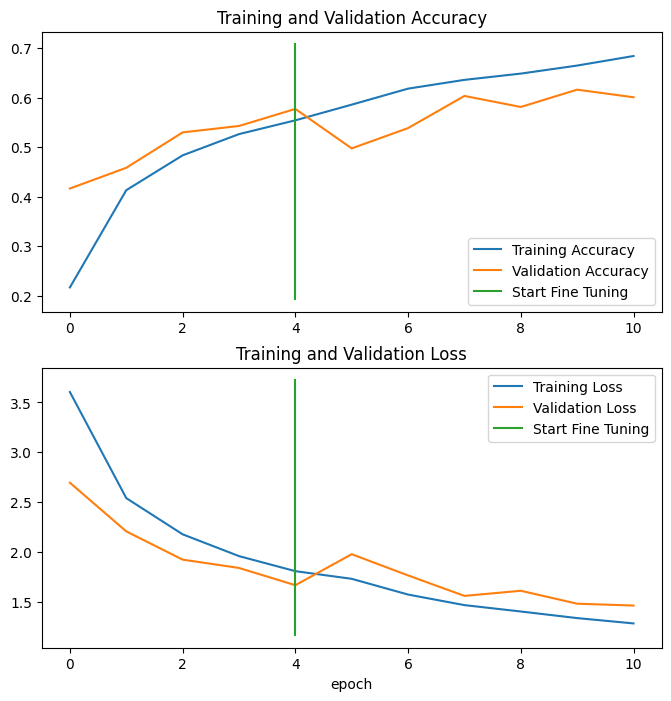

In [23]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [26]:
# Save our fine-tuning model
model.save("/content/drive/MyDrive/Colab Notebooks/Tensorflow/neural_network_classification/Project/Multiclass image classification/models/101_food_classes_10_percent_saved_big_dog_model.keras")

In [27]:
# Load an evaluate saved model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/Tensorflow/neural_network_classification/Project/Multiclass image classification/models/101_food_classes_10_percent_saved_big_dog_model.keras")

In [28]:
# Evaluate loaded model and compare performance to pre-saved model
loaded_model_results = loaded_model.evaluate(test_data)
loaded_model_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 67s 80ms/step - accuracy: 0.5317 - loss: 1.8121


[1.6917388439178467, 0.5567128658294678]

In [29]:
# The results from our loaded_model (above) should be very similar to the results below
results_all_classes_10_percent_fine_tune

[1.6131987571716309, 0.5740594267845154]

## Evaluating the performance of the big dog model across all different classes

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [30]:
import tensorflow as tf

# Download pretrained model (one that was prepared earlier, so all predictions are similar)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-09-13 07:54:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.207, 173.194.210.207, 173.194.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   116MB/s    in 0.4s    

2024-09-13 07:54:29 (116 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [31]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [39]:
# # Load in saved model
model = tf.saved_model.load("/content/06_101_food_class_10_percent_saved_big_dog_model")

#model = tf.saved_model.load("/content/06_101_food_class_10_percent_saved_big_dog_model")
# model = tf.keras.models.Model(inputs=model.inputs, outputs=model.outputs)
# # Compile the Keras model (optional)
# model.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(), metrics=["accuracy"])

AttributeError: '_UserObject' object has no attribute 'inputs'

In [47]:
# Evaluate loaded model (the one we just downloaded on test data)
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

In [ ]:
# Make predictions with model
preds_probs = model.predict(test_data, verbose=1) # set verbosity to see how long is left

In [ ]:
len(test_data)

In [ ]:
# How many predictions are there?
len(preds_probs)

In [ ]:
# What's the shape of our predictions?
preds_probs.shape

In [ ]:
# Let's see what the first 10 predictions look like
preds_probs[:10]

In [ ]:
# What does the first prediction probability array look like?
preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

In [ ]:
# We get one prediction probability per class (in our case there's 101 prediction probabilities)
print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

In [ ]:
# Get the pred classes of each label
pred_classes = preds_probs.argmax(axis=1)

# How do they look?
pred_classes[:10]